## Importing libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
import random

## Setting seed

In [3]:
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(42)

## Reading data

In [4]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [5]:
X_train, y_train = load_dataset('../ShanghaiTech/part_B/train_data/images/', '../ShanghaiTech/part_B/train_data/ground-truth/')

In [6]:
X_test, y_test = load_dataset('../ShanghaiTech/part_B/test_data/images/', '../ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False ## Not trainable weights

# base_model.trainable = True
# for layer in base_model.layers[:-3]:
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [8]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 161s 12s/step - loss: 19841.5625 - mae: 107.2772 - val_loss: 9848.3506 - val_mae: 79.3276
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 10s/step - loss: 9377.4023 - mae: 75.9578 - val_loss: 8003.1592 - val_mae: 67.2600
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 128s 10s/step - loss: 7626.2891 - mae: 63.6308 - val_loss: 6901.2349 - val_mae: 58.4406
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 156s 12s/step - loss: 7528.2744 - mae: 62.5249 - val_loss: 6341.4580 - val_mae: 57.0527
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 123s 10s/step - loss: 6630.9243 - mae: 59.4052 - val_loss: 5746.6211 - val_mae: 50.0272
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 129s 10s/step - loss: 5878.0527 - mae: 53.9876 - val_loss: 5460.9463 - val_mae: 51.4655
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 128s 10s/step - loss: 5356.8071 - mae: 53.5272 - val_loss: 5040.1562 - val_mae: 46.1031
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 130s 10s/step - loss: 5127.1128 - mae: 49.7186 - val_loss: 4782.2646 - val_mae

## Training curves visualisation

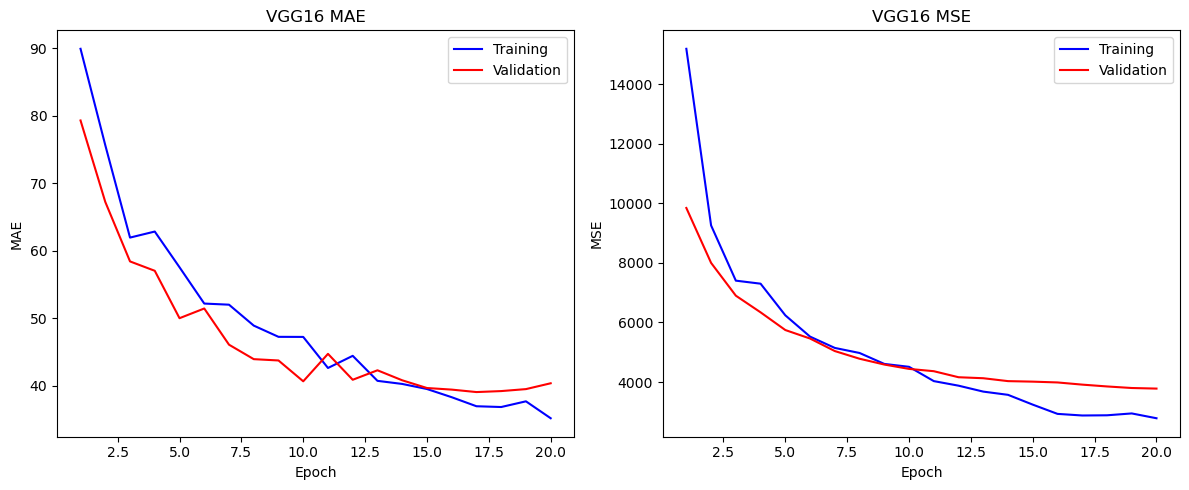

In [9]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('VGG16 MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('VGG16 MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [10]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step


In [11]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 12.  23.]
 [226. 181.]
 [157. 157.]
 [ 19.  37.]
 [ 95.  70.]
 [ 65.  57.]
 [ 34.  44.]
 [288. 227.]
 [165. 165.]
 [342. 476.]
 [158. 139.]
 [227. 316.]
 [228. 164.]
 [ 82. 110.]
 [ 30.  20.]
 [193. 131.]
 [ 84.  48.]
 [172. 183.]
 [178. 101.]
 [266. 204.]
 [ 49.  40.]
 [144. 143.]
 [202. 146.]
 [285. 513.]
 [ 66.  70.]
 [167. 175.]
 [ 22.  51.]
 [147.  55.]
 [ 68.  67.]
 [ 45.  72.]
 [ 42.  56.]
 [114. 165.]
 [ 12.  32.]
 [214. 149.]
 [ 53.  48.]
 [172.  80.]
 [191. 117.]
 [ 60. 162.]
 [191. 137.]
 [114. 120.]
 [ 62.  72.]
 [159. 122.]
 [236. 198.]
 [129. 133.]
 [102. 147.]
 [ 35.  29.]
 [ 41.  70.]
 [ 24.  35.]
 [ 66.  24.]
 [226. 251.]
 [ 71.  59.]
 [114.  67.]
 [ 89.  61.]
 [250. 248.]
 [296. 252.]
 [217. 147.]
 [ 52.  57.]
 [148. 121.]
 [ 46.  47.]
 [246. 505.]
 [243. 297.]
 [265. 465.]
 [183. 167.]
 [ 72.  43.]
 [ 77.  46.]
 [107.  91.]
 [207. 263.]
 [202.  92.]
 [ 67. 117.]
 [ 29.  48.]
 [ 45.  54.]
 [ 63.  73.]
 [ 76. 122.]
 [ 84.  60.]
 [239. 170.]
 [102. 167.]
 [ 40.  57.]

## Metrics

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5824692249298096
MSE: 3778.715087890625
MAE: 40.37974548339844
RMSE: 61.47125244140625
